<a href="https://colab.research.google.com/github/rish94abh/CS230_Project/blob/main/DeepLearning_IC_Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install opencv-python numpy svgpathtools pillow scikit-image tqdm matplotlib svgwrite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.9 MB/s eta 0:00:00


In [3]:
from google.colab import files
import os

os.makedirs("images", exist_ok=True)
os.makedirs("labels_svg", exist_ok=True)

# Upload your files manually
print("Please upload your image (.png) and SVG (.svg) files now.")
uploaded = files.upload()

# Move uploaded files to their respective directories and verify
found_image_files = []
for filename in uploaded.keys():
    if filename.endswith('.png'):
        target_path = os.path.join('images', filename)
        os.rename(filename, target_path)
        print(f"Moved {filename} to images/")
        found_image_files.append(target_path)
    elif filename.endswith('.svg'):
        target_path = os.path.join('labels_svg', filename)
        os.rename(filename, target_path)
        print(f"Moved {filename} to labels_svg/")
    else:
        print(f"Skipped unrecognized file: {filename}")

print("\n--- File Verification ---")
if not found_image_files:
    print("No .png images were found in the uploaded files. Please upload your image files.")
else:
    for img_path in found_image_files:
        if os.path.exists(img_path):
            file_size = os.path.getsize(img_path)
            print(f"Verified: {img_path} exists with size: {file_size} bytes.")
            if file_size == 0:
                print(f"WARNING: {img_path} is an empty file. This suggests a corrupted upload.")
        else:
            print(f"ERROR: {img_path} was expected but not found. This indicates an issue with moving the file.")


Please upload your image (.png) and SVG (.svg) files now.


Saving sem0002.png to sem0002.png
Saving sem0002.svg to sem0002.svg
Saving sem0003.png to sem0003.png
Saving sem0003.svg to sem0003.svg
Moved sem0002.png to images/
Moved sem0002.svg to labels_svg/
Moved sem0003.png to images/
Moved sem0003.svg to labels_svg/

--- File Verification ---
Verified: images/sem0002.png exists with size: 9598589 bytes.
Verified: images/sem0003.png exists with size: 9617060 bytes.


In [4]:
import cv2
import numpy as np
from svgpathtools import svg2paths
from PIL import Image, ImageDraw
import os

# Moved svg_to_mask definition here to ensure it's in scope for SEMSegDataset
def svg_to_mask(svg_path, image_size):
    """Convert an SVG file into a binary mask (numpy array)."""
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)

    # Parse SVG paths
    paths, _ = svg2paths(svg_path)
    for path in paths:
        points = [(seg.start.real, seg.start.imag) for seg in path]
        if len(points) > 2:
            draw.polygon(points, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import os

class SEMSegDataset(Dataset):
    def __init__(self, img_dir, svg_dir, resize_target=(1024, 1024), transform=None):
        self.img_dir = img_dir
        self.svg_dir = svg_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.resize_target = resize_target
        self.transform = transform # This transform will now only include ToTensor

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        svg_path = os.path.join(self.svg_dir, img_name.replace('.png', '.svg'))

        img = Image.open(img_path).convert('L')  # SEM images are grayscale, PIL Image
        mask_np = svg_to_mask(svg_path, img.size) # mask is numpy array (0 or 1)
        mask = Image.fromarray(mask_np) # Convert numpy mask to PIL Image (L mode)

        # Explicitly resize PIL Images before any further transformations
        if self.resize_target:
            img = transforms.Resize(self.resize_target)(img)
            mask = transforms.Resize(self.resize_target)(mask)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

Deeper U-Net

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # ---------- Encoder ----------
        self.enc_blocks = nn.ModuleList()
        self.pools = nn.ModuleList()

        ch = in_channels
        for feat in features:
            self.enc_blocks.append(self._block(ch, feat))
            self.pools.append(nn.MaxPool2d(2))
            ch = feat

        # ---------- Bottleneck ----------
        self.bottleneck = self._block(features[-1], features[-1] * 2)

        # ---------- Decoder ----------
        self.up_transpose = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()

        # Store reversed features for correct indexing
        rev_features = list(reversed(features))

        # Iterate in reverse order
        for i, feat in enumerate(rev_features):
            self.up_transpose.append(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            )

            # Calculate input channels for the decoder block
            if i == 0:
                # First decoder block: skip channels (features[-1]) + bottleneck output channels (features[-1] * 2)
                in_channels_dec_block = feat + (features[-1] * 2)
            else:
                # Subsequent decoder blocks: skip channels (feat) + upsampled output from previous decoder block (rev_features[i-1])
                in_channels_dec_block = feat + rev_features[i-1]

            self.dec_blocks.append(
                self._block(in_channels_dec_block, feat)
            )

        # ---------- Final conv ----------
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _block(self, in_ch, out_ch):
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
                self.norm1 = nn.InstanceNorm2d(out_channels)
                self.relu = nn.ReLU(inplace=True)
                self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
                self.norm2 = nn.InstanceNorm2d(out_channels)

                # Shortcut connection
                self.shortcut = nn.Sequential()
                if in_channels != out_channels:
                    self.shortcut = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                        nn.InstanceNorm2d(out_channels)
                    )

            def forward(self, x):
                identity = x # Store the input for residual connection

                out = self.conv1(x)
                out = self.norm1(out)
                out = self.relu(out)

                out = self.conv2(out)
                out = self.norm2(out)

                # Add shortcut to main path
                out += self.shortcut(identity)
                out = self.relu(out) # Apply ReLU after addition

                return out
        return ResidualBlock(in_ch, out_ch)

    def forward(self, x):
        skips = []

        # ---- Encoder ----
        for enc, pool in zip(self.enc_blocks, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)

        # ---- Bottleneck ----
        x = self.bottleneck(x)

        # ---- Decoder ----
        skips = skips[::-1]
        for i in range(len(self.up_transpose)):
            x = self.up_transpose[i](x)
            skip = skips[i]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.dec_blocks[i](x)

        # ---- Output ----
        return torch.sigmoid(self.final_conv(x))

Epoch 1/30: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch 1, loss=0.7526


Epoch 2/30: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 2, loss=0.2473


Epoch 3/30: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


Epoch 3, loss=0.1113


Epoch 4/30: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 4, loss=0.0600


Epoch 5/30: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch 5, loss=0.0366


Epoch 6/30: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch 6, loss=0.0246


Epoch 7/30: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch 7, loss=0.0176


Epoch 8/30: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Epoch 8, loss=0.0135


Epoch 9/30: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 9, loss=0.0109


Epoch 10/30: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Epoch 10, loss=0.0092


Epoch 11/30: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch 11, loss=0.0082


Epoch 12/30: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch 12, loss=0.0074


Epoch 13/30: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 13, loss=0.0069


Epoch 14/30: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch 14, loss=0.0065


Epoch 15/30: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch 15, loss=0.0063


Epoch 16/30: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 16, loss=0.0061


Epoch 17/30: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch 17, loss=0.0059


Epoch 18/30: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 18, loss=0.0058


Epoch 19/30: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch 19, loss=0.0057


Epoch 20/30: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch 20, loss=0.0056


Epoch 21/30: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch 21, loss=0.0055


Epoch 22/30: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


Epoch 22, loss=0.0055


Epoch 23/30: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch 23, loss=0.0054


Epoch 24/30: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch 24, loss=0.0054


Epoch 25/30: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Epoch 25, loss=0.0053


Epoch 26/30: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch 26, loss=0.0053


Epoch 27/30: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch 27, loss=0.0053


Epoch 28/30: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Epoch 28, loss=0.0053


Epoch 29/30: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


Epoch 29, loss=0.0052


Epoch 30/30: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch 30, loss=0.0052


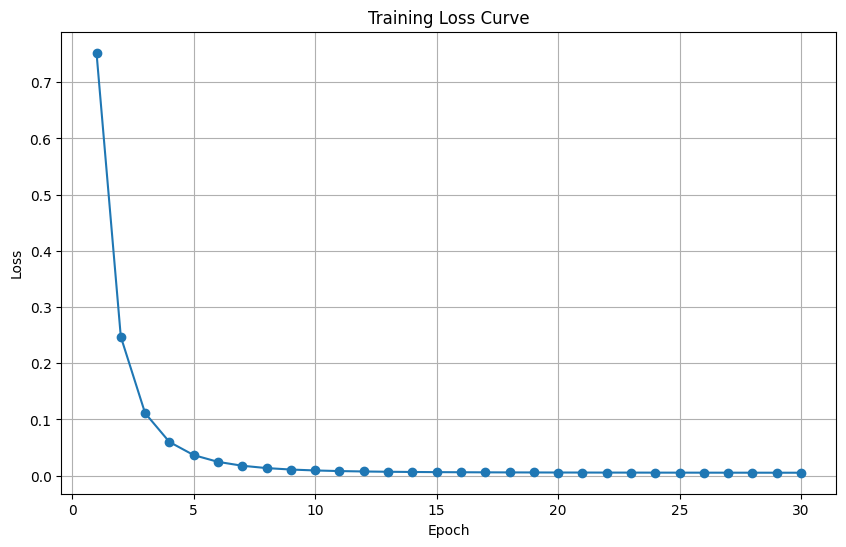

In [6]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

# Transform now only includes ToTensor, as Resize is handled in the Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
# Pass the resize_target to the Dataset constructor
dataset = SEMSegDataset('images/', 'labels_svg/', resize_target=(1024, 1024), transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.BCELoss() # Changed to BCELoss

num_epochs = 30
training_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for img, mask in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = loss_fn(pred, mask)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(loader)
    training_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}, loss={avg_epoch_loss:.4f}")

torch.save(model.state_dict(), 'unet_sem.pth')

# Plotting the training curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [7]:
import matplotlib.pyplot as plt

def predict_mask(model, image_path):
    img = Image.open(image_path).convert('L')
    # Resize the image to match the input size the model was trained on
    resize_transform = transforms.Resize((1024, 1024))
    img_resized = resize_transform(img)
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_tensor).cpu().numpy()[0, 0]
    # Lower the threshold to 0.1 to capture more features
    mask = (pred > 0.002).astype(np.uint8) * 255
    return mask, pred # Return both binary mask and raw prediction

In [8]:
from skimage import measure
import svgwrite

def mask_to_svg(mask, output_svg_path):
    contours = measure.find_contours(mask, 0.5)
    dwg = svgwrite.Drawing(output_svg_path, profile='tiny')
    for contour in contours:
        points = [(float(x), float(y)) for y, x in contour]
        dwg.add(dwg.polygon(points, fill='none', stroke='red', stroke_width=1))
    dwg.save()

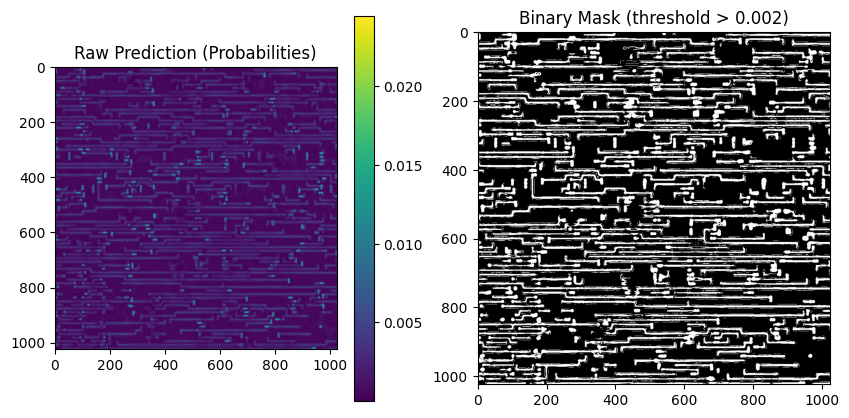

In [10]:
mask, raw_pred = predict_mask(model, 'sem0000.png')
mask_to_svg(mask, 'sem0010_pred.svg')

# Visualize the raw prediction and the binary mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Raw Prediction (Probabilities)')
plt.imshow(raw_pred, cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Binary Mask (threshold > 0.002)')
plt.imshow(mask, cmap='gray')

plt.show()